# Understanding the Reweight and Deduplication Process

## Imports and Dependencies

In [44]:
import logging
from datetime import datetime
from typing import Dict, List, Tuple

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


In [26]:
question_ds = load_dataset("sumuks/yourbench_y1_single_hop_questions", split="train")
question_ds

Dataset({
    features: ['question_id', 'document_id', 'document_name', 'document_category', 'document_summary', 'chunk_location_id', 'chunk', 'test_audience', 'full_generation_response', 'document_analysis', 'question_type', 'thought_process', 'question', 'answer', 'estimated_difficulty', 'citations', 'generating_model'],
    num_rows: 27769
})

In [17]:
question_df = question_ds.to_pandas()
question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   question_id               27769 non-null  object
 1   document_id               27769 non-null  object
 2   document_name             27769 non-null  object
 3   document_category         27769 non-null  object
 4   document_summary          27769 non-null  object
 5   chunk_location_id         27769 non-null  int64 
 6   chunk                     27769 non-null  object
 7   test_audience             27769 non-null  object
 8   full_generation_response  27769 non-null  object
 9   document_analysis         27769 non-null  object
 10  question_type             27769 non-null  object
 11  thought_process           27769 non-null  object
 12  question                  27769 non-null  object
 13  answer                    27769 non-null  object
 14  estimated_difficulty  

In [19]:
def group_by_question_type(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Groups the dataset by question type and returns a dictionary of dataframes.

    Args:
        df: Input DataFrame containing question-answer pairs

    Returns:
        Dictionary mapping question types to their respective DataFrames
    """
    return dict(df.groupby('question_type'))


def create_qa_representation(row: pd.Series, separator: str = " [SEP] ") -> str:
    """
    Creates a combined representation of question and answer.

    Args:
        row: DataFrame row containing 'question' and 'answer' columns
        separator: String to use as separator between question and answer

    Returns:
        Combined question-answer string
    """
    return f"{row['question']}{separator}{row['answer']}"


def process_qa_dataset(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Main processing function that groups by question type and adds combined representations.

    Args:
        df: Input DataFrame containing question-answer pairs

    Returns:
        Dictionary of processed DataFrames grouped by question type
    """
    # Group by question type
    grouped_data = group_by_question_type(df)

    # Add combined representations to each group
    for qtype, group_df in grouped_data.items():
        grouped_data[qtype]['qa_combined'] = group_df.apply(create_qa_representation, axis=1)

    return grouped_data

In [20]:
grouped_qa_data = process_qa_dataset(question_df)

In [29]:
def compute_embeddings(texts: List[str], model_name: str = "all-MiniLM-L6-v2", batch_size: int = 32) -> np.ndarray:
    """
    Compute embeddings for a list of texts using a sentence transformer model.

    Args:
        texts: List of texts to embed
        model_name: Name of the sentence transformer model to use
        batch_size: Batch size for embedding computation

    Returns:
        Array of embeddings
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SentenceTransformer(model_name).to(device)

    # Compute embeddings with progress bar
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Computing embeddings"):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch, convert_to_tensor=True, device=device)
        embeddings.append(batch_embeddings.cpu().numpy())

    return np.vstack(embeddings)


def setup_logging(question_type: str) -> logging.Logger:
    """
    Sets up logging configuration for a specific question type.

    Args:
        question_type: The type of questions being processed

    Returns:
        Configured logger instance
    """
    # Create timestamp for unique log file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_filename = f"deduplication_{question_type}_{timestamp}.log"

    # Configure logger
    logger = logging.getLogger(f"dedup_{question_type}")
    logger.setLevel(logging.INFO)

    # Create file handler
    fh = logging.FileHandler(log_filename)
    fh.setLevel(logging.INFO)

    # Create formatter
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    fh.setFormatter(formatter)

    # Add handler to logger
    logger.addHandler(fh)

    return logger


def deduplicate_embeddings(embeddings: np.ndarray,
                         df: pd.DataFrame,
                         eps: float = 0.1,
                         min_samples: int = 2,
                         question_type: str = "unknown") -> Tuple[pd.DataFrame, Dict]:
    """
    Deduplicate data points based on their embeddings using DBSCAN clustering.

    Args:
        embeddings: Array of embeddings
        df: DataFrame containing the original data
        eps: DBSCAN epsilon parameter (similarity threshold)
        min_samples: DBSCAN min_samples parameter

    Returns:
        Tuple of (deduplicated DataFrame, clustering info dictionary)
    """
    # Set up logging
    logger = setup_logging(question_type)
    logger.info(f"Starting deduplication for question type: {question_type}")
    logger.info(f"Parameters: eps={eps}, min_samples={min_samples}")
    logger.info(f"Initial dataset size: {len(df)}")

    # Perform DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
    clusters = clustering.fit_predict(embeddings)

    # Create a mapping of cluster labels to indices
    cluster_indices = {}
    for idx, label in enumerate(clusters):
        if label != -1:  # -1 represents noise points in DBSCAN
            if label not in cluster_indices:
                cluster_indices[label] = []
            cluster_indices[label].append(idx)

    # Select representative samples from each cluster
    keep_indices = []
    cluster_info = {}

    # Keep isolated points (noise)
    noise_points = np.where(clusters == -1)[0]
    keep_indices.extend(noise_points)

    # For each cluster, select the most central point
    for label, indices in cluster_indices.items():
        if len(indices) > 1:
            cluster_embeddings = embeddings[indices]
            centroid = np.mean(cluster_embeddings, axis=0)

            # Find the point closest to centroid
            distances = cosine_similarity([centroid], cluster_embeddings)[0]
            central_idx = indices[np.argmax(distances)]

            keep_indices.append(central_idx)

            # Log cluster information
            logger.info(f"\nCluster {label}:")
            logger.info(f"Cluster size: {len(indices)}")
            logger.info("Representative (central) QA pair:")
            logger.info(f"Q: {df.iloc[central_idx]['question']}")
            logger.info(f"A: {df.iloc[central_idx]['answer']}")
            logger.info("\nOther cluster members:")
            for idx in indices:
                if idx != central_idx:
                    logger.info(f"Q: {df.iloc[idx]['question']}")
                    logger.info(f"A: {df.iloc[idx]['answer']}")
            logger.info("-" * 80)

            cluster_info[label] = {
                'size': len(indices),
                'representative_idx': central_idx,
                'member_indices': indices
            }

    # Create deduplicated dataframe
    deduplicated_df = df.iloc[sorted(keep_indices)].copy()

    # Calculate and log shrinkage metrics
    original_size = len(df)
    dedup_size = len(deduplicated_df)
    shrinkage_factor = (original_size - dedup_size) / original_size * 100

    logger.info("\nFinal Deduplication Statistics:")
    logger.info(f"Original dataset size: {original_size}")
    logger.info(f"Deduplicated dataset size: {dedup_size}")
    logger.info(f"Shrinkage factor: {shrinkage_factor:.2f}%")
    logger.info(f"Number of clusters: {len(cluster_info)}")
    logger.info(f"Number of noise points (unique QAs): {len(noise_points)}")

    return deduplicated_df, cluster_info


def process_and_deduplicate(df: pd.DataFrame,
                          eps: float = 0.1,
                          min_samples: int = 2,
                          model_name: str = "all-MiniLM-L6-v2") -> Dict[str, Tuple[pd.DataFrame, Dict]]:
    """
    Complete pipeline to process and deduplicate QA pairs by question type.

    Args:
        df: Input DataFrame
        eps: DBSCAN epsilon parameter
        min_samples: DBSCAN min_samples parameter
        model_name: Name of the sentence transformer model

    Returns:
        Dictionary mapping question types to (deduplicated_df, cluster_info) tuples
    """
    # First group and create combined representations
    grouped_data = process_qa_dataset(df)
    results = {}

    # Process each question type separately
    for qtype, group_df in grouped_data.items():
        print(f"\nProcessing question type: {qtype}")

        # Compute embeddings
        embeddings = compute_embeddings(group_df['qa_combined'].tolist())

        # Deduplicate
        dedup_df, cluster_info = deduplicate_embeddings(
            embeddings,
            group_df,
            eps=eps,
            min_samples=min_samples,
            question_type=qtype
        )

        results[qtype] = (dedup_df, cluster_info)

        # Print summary
        print(f"Original size: {len(group_df)}")
        print(f"Deduplicated size: {len(dedup_df)}")
        print(f"Number of clusters: {len(cluster_info)}")

    return results

In [30]:
results = process_and_deduplicate(
    question_df,
    eps=0.1,
    min_samples=2,
    model_name="all-MiniLM-L6-v2"
)


Processing question type: analytical


Computing embeddings: 100%|██████████| 215/215 [00:03<00:00, 54.22it/s]


Original size: 6859
Deduplicated size: 5555
Number of clusters: 410

Processing question type: application-based


Computing embeddings: 100%|██████████| 148/148 [00:02<00:00, 55.13it/s]


Original size: 4706
Deduplicated size: 4069
Number of clusters: 176

Processing question type: clarification


Computing embeddings: 100%|██████████| 80/80 [00:01<00:00, 58.33it/s]


Original size: 2548
Deduplicated size: 2315
Number of clusters: 101

Processing question type: conceptual


Computing embeddings: 100%|██████████| 183/183 [00:03<00:00, 56.59it/s]


Original size: 5848
Deduplicated size: 5018
Number of clusters: 343

Processing question type: counterfactual


Computing embeddings: 100%|██████████| 63/63 [00:01<00:00, 60.25it/s]


Original size: 2009
Deduplicated size: 1837
Number of clusters: 63

Processing question type: edge-case


Computing embeddings: 100%|██████████| 15/15 [00:00<00:00, 55.40it/s]


Original size: 477
Deduplicated size: 475
Number of clusters: 2

Processing question type: factual


Computing embeddings: 100%|██████████| 86/86 [00:01<00:00, 68.25it/s]


Original size: 2727
Deduplicated size: 2241
Number of clusters: 266

Processing question type: false-premise


Computing embeddings: 100%|██████████| 10/10 [00:00<00:00, 64.61it/s]


Original size: 318
Deduplicated size: 307
Number of clusters: 6

Processing question type: open-ended


Computing embeddings: 100%|██████████| 52/52 [00:00<00:00, 60.17it/s]


Original size: 1651
Deduplicated size: 1493
Number of clusters: 46

Processing question type: true-false


Computing embeddings: 100%|██████████| 20/20 [00:00<00:00, 84.52it/s]


Original size: 626
Deduplicated size: 570
Number of clusters: 22


In [37]:
def evaluate_eps_value(embeddings: np.ndarray,
                      df: pd.DataFrame,
                      eps: float,
                      min_samples: int = 2) -> Dict:
    """
    Evaluate a single eps value and return metrics.

    Args:
        embeddings: Precomputed embeddings
        df: Original DataFrame
        eps: DBSCAN eps parameter to test
        min_samples: DBSCAN min_samples parameter

    Returns:
        Dictionary containing evaluation metrics
    """
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
    clusters = clustering.fit_predict(embeddings)

    # Calculate metrics
    n_clusters = len(set(clusters[clusters != -1]))
    n_noise = list(clusters).count(-1)
    cluster_sizes = pd.Series(clusters[clusters != -1]).value_counts().describe()

    return {
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'shrinkage': (len(df) - (n_noise + n_clusters)) / len(df) * 100,
        'avg_cluster_size': cluster_sizes['mean'] if n_clusters > 0 else 0,
        'max_cluster_size': cluster_sizes['max'] if n_clusters > 0 else 0,
        'min_cluster_size': cluster_sizes['min'] if n_clusters > 0 else 0
    }


def tune_eps_parameter(embeddings: np.ndarray,
                      df: pd.DataFrame,
                      eps_range: List[float] = None,
                      min_samples: int = 2) -> pd.DataFrame:
    """
    Perform parameter sweep over eps values.

    Args:
        embeddings: Precomputed embeddings
        df: Original DataFrame
        eps_range: List of eps values to test
        min_samples: DBSCAN min_samples parameter

    Returns:
        DataFrame containing evaluation results
    """
    if eps_range is None:
        eps_range = np.linspace(0.05, 0.3, 20)

    results = []
    for eps in tqdm(eps_range, desc="Testing eps values"):
        metrics = evaluate_eps_value(embeddings, df, eps, min_samples)
        results.append(metrics)

    return pd.DataFrame(results)


def plot_eps_tuning_results(results_df: pd.DataFrame, save_path: str = None):
    """
    Create visualization of eps tuning results.

    Args:
        results_df: DataFrame containing tuning results
        save_path: Optional path to save the plot
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=300)
    fig.suptitle('DBSCAN Epsilon Parameter Tuning Results', fontsize=14, y=0.95)

    # Plot 1: Shrinkage and Number of Clusters
    ax1.plot(results_df['eps'], results_df['shrinkage'],
             'b-', label='Shrinkage %', linewidth=2)
    ax1.set_ylabel('Shrinkage %', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax1_twin = ax1.twinx()
    ax1_twin.plot(results_df['eps'], results_df['n_clusters'],
                 'r--', label='Number of Clusters', linewidth=2)
    ax1_twin.set_ylabel('Number of Clusters', color='r')
    ax1_twin.tick_params(axis='y', labelcolor='r')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # Plot 2: Cluster Sizes
    ax2.plot(results_df['eps'], results_df['avg_cluster_size'],
            label='Average Cluster Size', linewidth=2)
    ax2.plot(results_df['eps'], results_df['max_cluster_size'],
            label='Max Cluster Size', linewidth=2)
    ax2.fill_between(results_df['eps'],
                    results_df['min_cluster_size'],
                    results_df['max_cluster_size'],
                    alpha=0.2)

    ax2.set_xlabel('Epsilon Value')
    ax2.set_ylabel('Cluster Size')
    ax2.legend()

    # Add grid and styling
    ax1.grid(True, alpha=0.3)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


def find_optimal_eps(results_df: pd.DataFrame,
                    target_shrinkage: float = None,
                    max_cluster_size: int = None) -> float:
    """
    Find optimal eps value based on criteria.

    Args:
        results_df: DataFrame containing tuning results
        target_shrinkage: Target shrinkage percentage
        max_cluster_size: Maximum acceptable cluster size

    Returns:
        Recommended eps value
    """
    if target_shrinkage:
        # Find eps that gives closest to target shrinkage
        idx = (results_df['shrinkage'] - target_shrinkage).abs().idxmin()
        return results_df.iloc[idx]['eps']

    if max_cluster_size:
        # Find largest eps that keeps max cluster size below threshold
        valid_results = results_df[results_df['max_cluster_size'] <= max_cluster_size]
        if len(valid_results) > 0:
            return valid_results['eps'].max()

    # Default: Find elbow point in shrinkage curve
    from kneed import KneeLocator
    kneedle = KneeLocator(results_df['eps'],
                         results_df['shrinkage'],
                         S=1.0,
                         curve='concave',
                         direction='increasing')
    return kneedle.elbow

Testing eps values: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


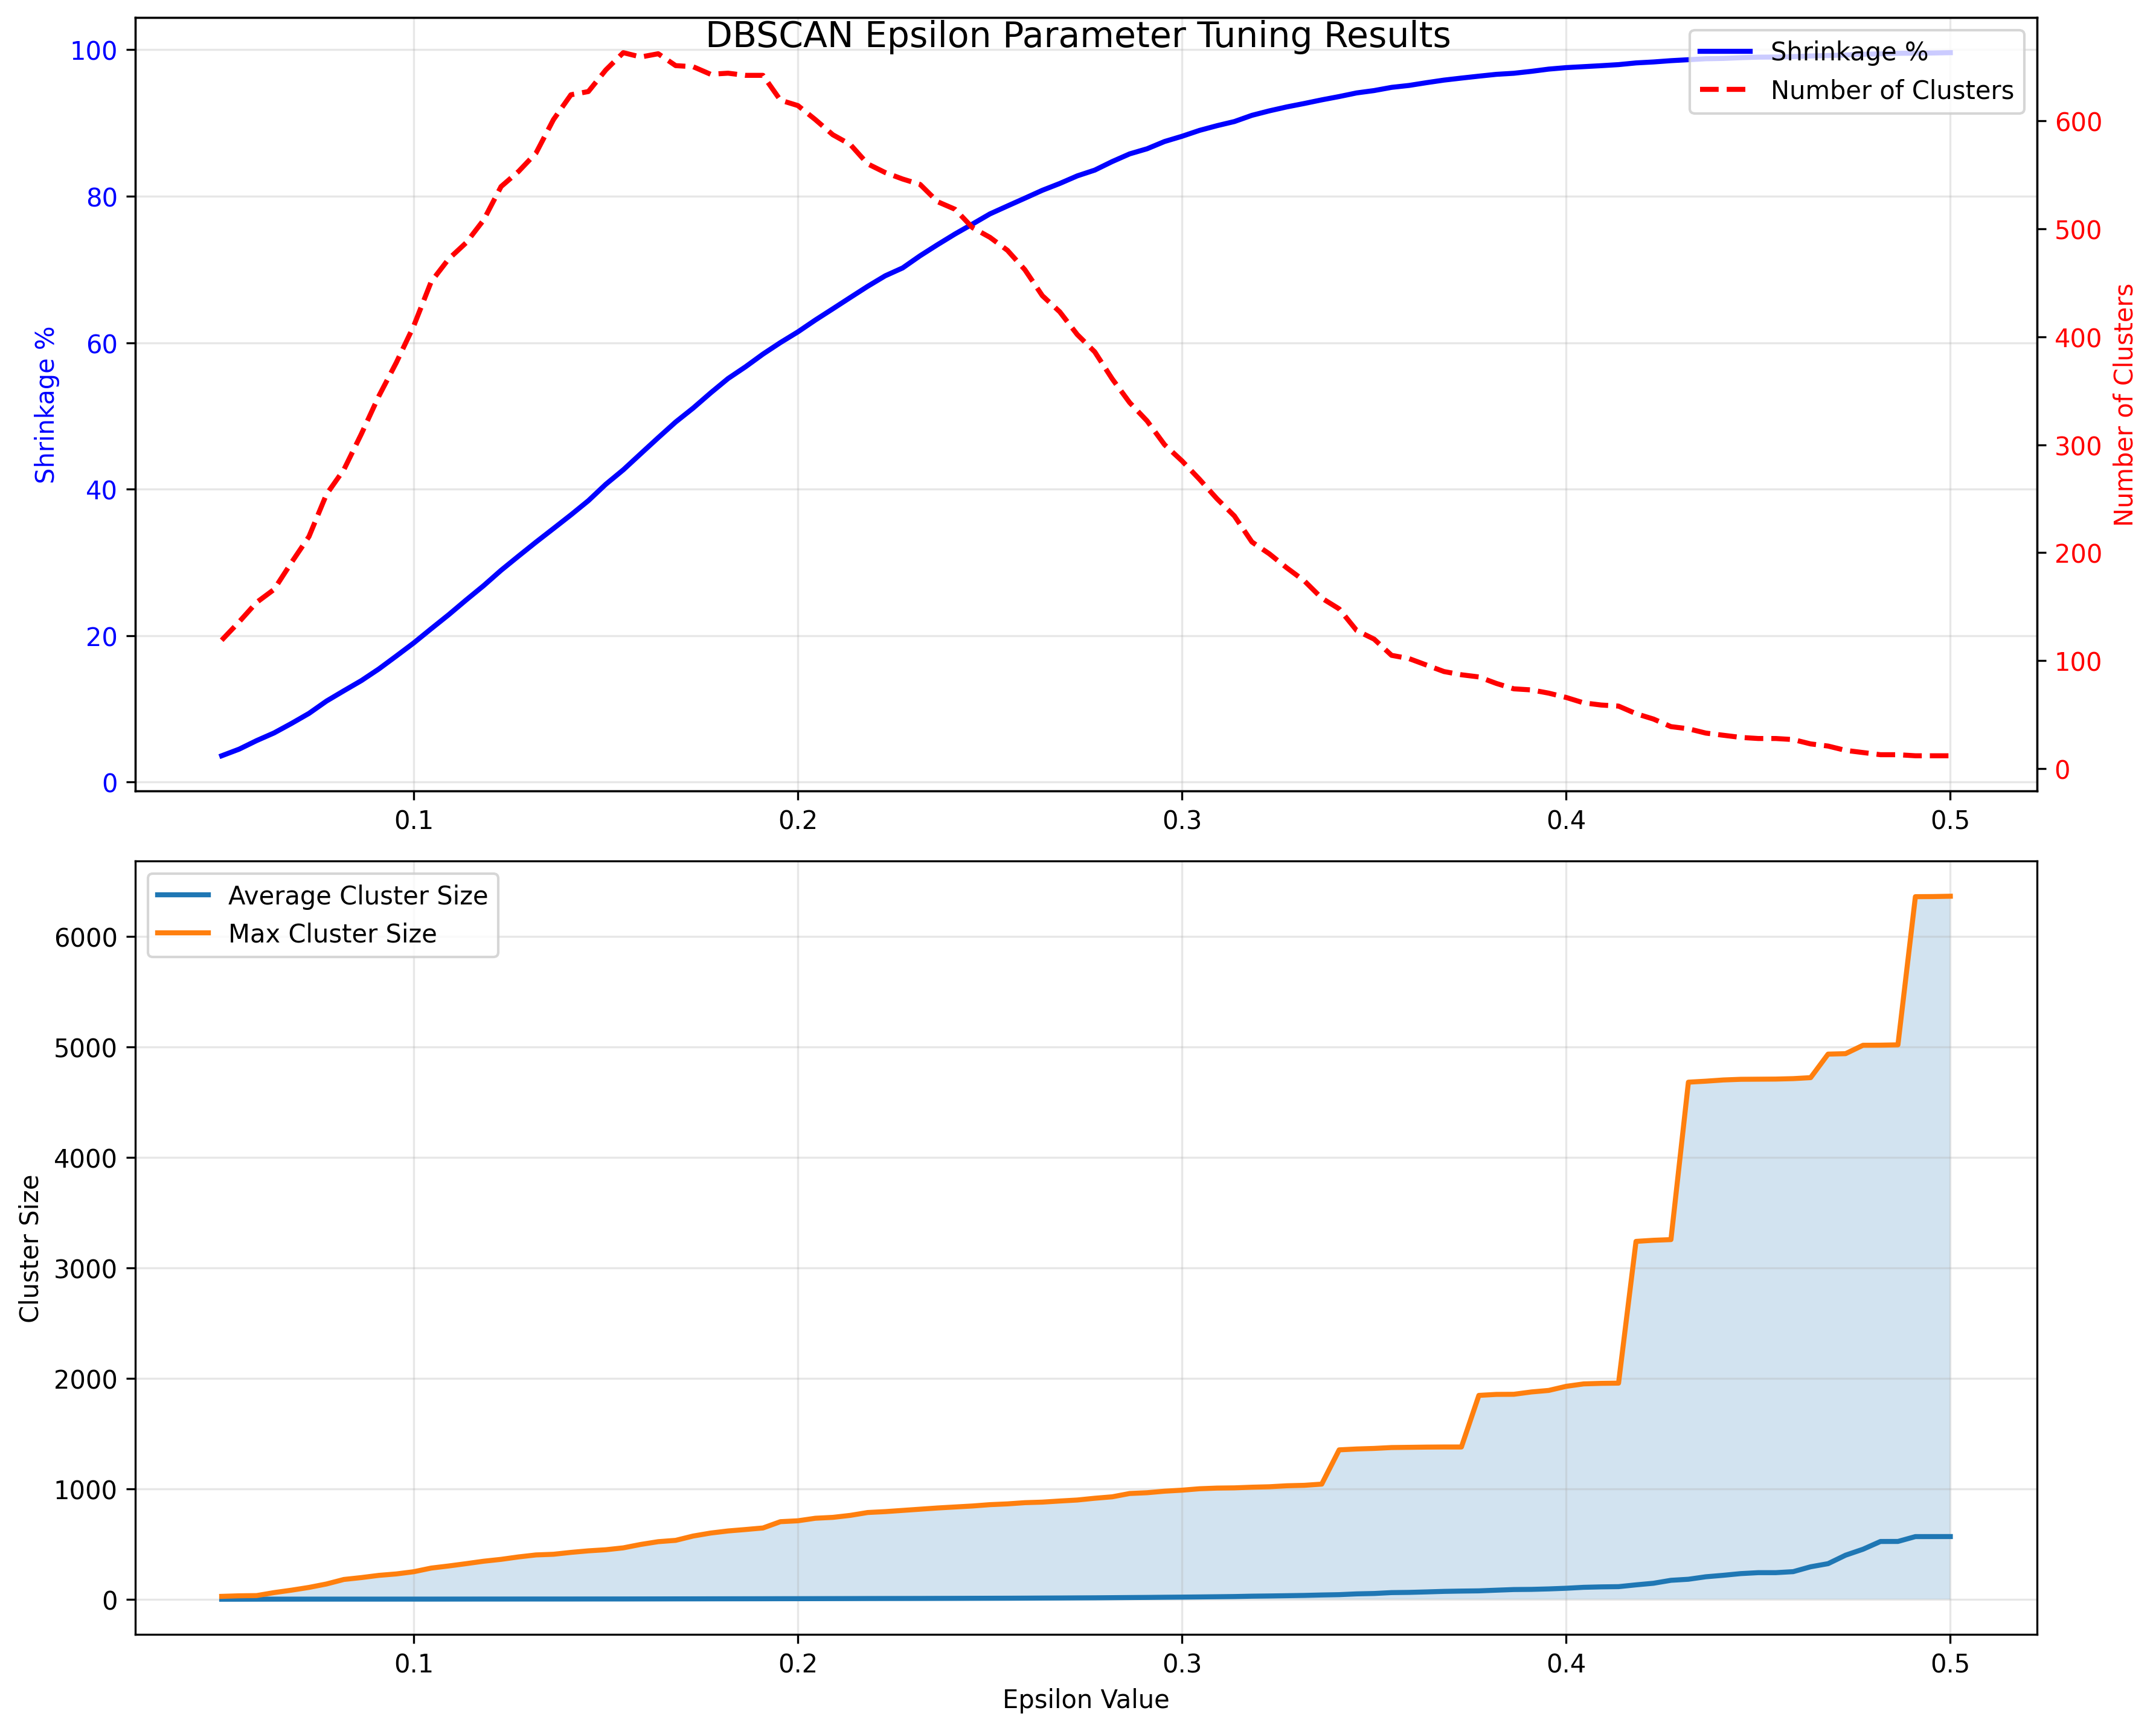

Recommended eps value: 0.168


In [39]:
# First, compute embeddings for one question type
grouped_data = process_qa_dataset(question_df)
qtype = list(grouped_data.keys())[0]  # Pick one question type to tune
group_df = grouped_data[qtype]
embeddings = compute_embeddings(group_df['qa_combined'].tolist())

# Run parameter sweep
eps_range = np.linspace(0.05, 0.5, 100)  # Test 20 values between 0.05 and 0.3
results = tune_eps_parameter(embeddings, group_df, eps_range)

# Visualize results
plot_eps_tuning_results(results, save_path=f'eps_tuning_{qtype}.png')

# Get recommended eps value
optimal_eps = find_optimal_eps(
    results,
    target_shrinkage=50,  # Optional: target specific shrinkage
    max_cluster_size=10   # Optional: limit maximum cluster size
)

print(f"Recommended eps value: {optimal_eps:.3f}")

In [47]:
def analyze_all_question_types(grouped_data: Dict[str, pd.DataFrame],
                             eps_range: np.ndarray = None,
                             min_samples: int = 2,
                             model_name: str = "all-MiniLM-L6-v2") -> Dict[str, pd.DataFrame]:
    """
    Analyze eps parameter impact across all question types.

    Args:
        grouped_data: Dictionary of DataFrames grouped by question type
        eps_range: Range of eps values to test
        min_samples: DBSCAN min_samples parameter
        model_name: Name of the embedding model to use

    Returns:
        Dictionary mapping question types to their tuning results
    """
    if eps_range is None:
        eps_range = np.linspace(0.05, 0.3, 20)

    results = {}

    for qtype, df in tqdm(grouped_data.items(), desc="Processing question types"):
        print(f"\nAnalyzing question type: {qtype}")
        # Compute embeddings
        embeddings = compute_embeddings(df['qa_combined'].tolist(), model_name=model_name)

        # Run parameter sweep
        tuning_results = tune_eps_parameter(embeddings, df, eps_range, min_samples)
        tuning_results['question_type'] = qtype
        results[qtype] = tuning_results

    return results


def plot_comprehensive_comparison(results_dict: Dict[str, pd.DataFrame],
                                save_path: str = "eps_tuning_comparison.png"):
    """
    Create comprehensive visualization comparing eps tuning across question types.

    Args:
        results_dict: Dictionary of tuning results per question type
        save_path: Path to save the resulting plot
    """

    # Create figure with GridSpec
    fig = plt.figure(figsize=(20, 25), dpi=300)
    gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1])

    # Combine all results
    pd.concat(results_dict.values(), ignore_index=True)
    question_types = list(results_dict.keys())

    # 1. Shrinkage Comparison
    ax1 = fig.add_subplot(gs[0, :])
    for qtype in question_types:
        data = results_dict[qtype]
        ax1.plot(data['eps'], data['shrinkage'],
                label=qtype, linewidth=2, marker='o', markersize=4)

    ax1.set_title('Shrinkage Percentage by Question Type', fontsize=14, pad=20)
    ax1.set_xlabel('Epsilon Value')
    ax1.set_ylabel('Shrinkage %')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    # 2. Number of Clusters
    ax2 = fig.add_subplot(gs[1, 0])
    for qtype in question_types:
        data = results_dict[qtype]
        ax2.plot(data['eps'], data['n_clusters'],
                label=qtype, linewidth=2, marker='o', markersize=4)

    ax2.set_title('Number of Clusters by Question Type', fontsize=14)
    ax2.set_xlabel('Epsilon Value')
    ax2.set_ylabel('Number of Clusters')
    ax2.grid(True, alpha=0.3)

    # 3. Average Cluster Size
    ax3 = fig.add_subplot(gs[1, 1])
    for qtype in question_types:
        data = results_dict[qtype]
        ax3.plot(data['eps'], data['avg_cluster_size'],
                label=qtype, linewidth=2, marker='o', markersize=4)

    ax3.set_title('Average Cluster Size by Question Type', fontsize=14)
    ax3.set_xlabel('Epsilon Value')
    ax3.set_ylabel('Average Cluster Size')
    ax3.grid(True, alpha=0.3)

    # 4. Distribution Plot of Cluster Sizes
    ax4 = fig.add_subplot(gs[2, :])
    eps_mid = eps_range[len(eps_range) // 2]  # Middle eps value
    cluster_sizes_data = []

    for qtype in question_types:
        data = results_dict[qtype]
        mid_eps_row = data[data['eps'] == eps_mid].iloc[0]
        cluster_sizes_data.append({
            'question_type': qtype,
            'min_size': mid_eps_row['min_cluster_size'],
            'avg_size': mid_eps_row['avg_cluster_size'],
            'max_size': mid_eps_row['max_cluster_size']
        })

    cluster_sizes_df = pd.DataFrame(cluster_sizes_data)

    # Create violin plot
    sns.violinplot(data=cluster_sizes_df.melt(id_vars=['question_type'],
                                            var_name='metric',
                                            value_name='size'),
                  x='question_type', y='size', hue='metric', ax=ax4)
    ax4.set_title(f'Cluster Size Distribution at eps={eps_mid:.2f}', fontsize=14)
    ax4.set_xlabel('Question Type')
    ax4.set_ylabel('Cluster Size')

    # 5. Heatmap of Optimal eps Values
    ax5 = fig.add_subplot(gs[3, :])
    optimal_eps_data = []

    for qtype, data in results_dict.items():
        optimal_eps = find_optimal_eps(data)
        metrics_at_optimal = data[data['eps'] == optimal_eps].iloc[0]
        optimal_eps_data.append({
            'question_type': qtype,
            'optimal_eps': optimal_eps,
            'shrinkage': metrics_at_optimal['shrinkage'],
            'n_clusters': metrics_at_optimal['n_clusters'],
            'avg_cluster_size': metrics_at_optimal['avg_cluster_size']
        })

    optimal_df = pd.DataFrame(optimal_eps_data).set_index('question_type')
    sns.heatmap(optimal_df, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax5)
    ax5.set_title('Optimal eps Values and Corresponding Metrics by Question Type', fontsize=14)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

    return optimal_df


def generate_summary_report(results_dict: Dict[str, pd.DataFrame],
                          optimal_df: pd.DataFrame) -> str:
    """
    Generate a detailed summary report of the analysis.

    Args:
        results_dict: Dictionary of tuning results per question type
        optimal_df: DataFrame containing optimal eps values and metrics

    Returns:
        Formatted summary report string
    """
    report = ["# Epsilon Parameter Tuning Analysis Report\n"]

    # Overall statistics
    report.append("## Overall Statistics\n")
    for qtype, data in results_dict.items():
        report.append(f"\n### Question Type: {qtype}")
        report.append(f"- Dataset size: {len(grouped_data[qtype])}")
        report.append(f"- Optimal eps: {optimal_df.loc[qtype, 'optimal_eps']:.3f}")
        report.append(f"- Achieved shrinkage: {optimal_df.loc[qtype, 'shrinkage']:.1f}%")
        report.append(f"- Number of clusters: {optimal_df.loc[qtype, 'n_clusters']:.0f}")
        report.append(f"- Average cluster size: {optimal_df.loc[qtype, 'avg_cluster_size']:.1f}")

    # Recommendations
    report.append("\n## Recommendations\n")
    for qtype in results_dict.keys():
        report.append(f"\n### {qtype}")
        eps = optimal_df.loc[qtype, 'optimal_eps']
        shrinkage = optimal_df.loc[qtype, 'shrinkage']
        report.append(f"- Recommended eps: {eps:.3f}")
        report.append(f"- Expected shrinkage: {shrinkage:.1f}%")

        # Add specific recommendations based on metrics
        if shrinkage < 20:
            report.append("- Consider increasing eps for more aggressive deduplication")
        elif shrinkage > 80:
            report.append("- Consider decreasing eps to preserve more diversity")

    return "\n".join(report)

In [48]:
# Run the analysis
eps_range = np.linspace(0.05, 0.3, 20)
results_dict = analyze_all_question_types(grouped_data, eps_range)

# Generate visualizations and report
optimal_df = plot_comprehensive_comparison(results_dict)
report = generate_summary_report(results_dict, optimal_df)

# Save report
with open("eps_tuning_report.md", "w") as f:
    f.write(report)

Processing question types:   0%|          | 0/10 [00:00<?, ?it/s]


Analyzing question type: analytical


Processing question types:  10%|█         | 1/10 [00:10<01:32, 10.31s/it]


Analyzing question type: application-based


Processing question types:  20%|██        | 2/10 [00:17<01:07,  8.41s/it]


Analyzing question type: clarification


Processing question types:  30%|███       | 3/10 [00:21<00:46,  6.67s/it]


Analyzing question type: conceptual


Processing question types:  40%|████      | 4/10 [00:29<00:42,  7.13s/it]


Analyzing question type: counterfactual


Processing question types:  50%|█████     | 5/10 [00:34<00:30,  6.06s/it]


Analyzing question type: edge-case


Processing question types:  60%|██████    | 6/10 [00:36<00:19,  4.81s/it]


Analyzing question type: factual


Processing question types:  70%|███████   | 7/10 [00:41<00:14,  4.75s/it]


Analyzing question type: false-premise


Processing question types:  80%|████████  | 8/10 [00:43<00:07,  3.96s/it]


Analyzing question type: open-ended


Processing question types:  90%|█████████ | 9/10 [00:46<00:03,  3.89s/it]


Analyzing question type: true-false


Processing question types: 100%|██████████| 10/10 [00:49<00:00,  4.93s/it]
